In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

# from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp

from encoding_information.models.pixel_cnn import PixelCNN
import tensorflow as tf



2023-10-22 10:30:48.045658: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 10:30:48.557799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

seed = 0

training_hyperparams = dict(
    learning_rate = 1e-2,
    batch_size = 32,
    steps_per_epoch = 200,
    max_epochs = 25,
    patience = 25,
    num_val_samples = 1000
)

# architecture hyperparams
num_hidden_channels = 64
num_mixture_components = 40

pixel_cnn = PixelCNN(num_hidden_channels=num_hidden_channels, num_mixture_components=num_mixture_components)
val_loss_history = pixel_cnn.fit(train_images, **training_hyperparams)

2023-10-22 10:31:05.583886: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Computing loss: 31it [00:03,  8.38it/s]


Initial validation NLL: 6.62


Epoch 1: 100%|██████████| 200/200 [00:12<00:00, 16.16it/s]
Computing loss: 31it [00:00, 130.52it/s]


Epoch 1: validation NLL: 1.72


Epoch 2: 100%|██████████| 200/200 [00:04<00:00, 46.91it/s]
Computing loss: 31it [00:00, 158.86it/s]


Epoch 2: validation NLL: 1.67


Epoch 3: 100%|██████████| 200/200 [00:03<00:00, 52.20it/s]
Computing loss: 31it [00:00, 156.68it/s]


Epoch 3: validation NLL: 1.68


Epoch 4: 100%|██████████| 200/200 [00:03<00:00, 50.30it/s]
Computing loss: 31it [00:00, 157.09it/s]


Epoch 4: validation NLL: 1.67


Epoch 5: 100%|██████████| 200/200 [00:03<00:00, 52.07it/s]
Computing loss: 31it [00:00, 166.51it/s]


Epoch 5: validation NLL: 1.66


Epoch 6: 100%|██████████| 200/200 [00:03<00:00, 51.49it/s]
Computing loss: 31it [00:00, 164.70it/s]


Epoch 6: validation NLL: 1.66


Epoch 7: 100%|██████████| 200/200 [00:03<00:00, 51.58it/s]
Computing loss: 31it [00:00, 160.50it/s]


Epoch 7: validation NLL: 1.65


Epoch 8: 100%|██████████| 200/200 [00:03<00:00, 50.80it/s]
Computing loss: 31it [00:00, 153.38it/s]


Epoch 8: validation NLL: 1.65


Epoch 9: 100%|██████████| 200/200 [00:03<00:00, 50.61it/s]
Computing loss: 31it [00:00, 166.59it/s]


Epoch 9: validation NLL: 1.65


Epoch 10: 100%|██████████| 200/200 [00:03<00:00, 51.25it/s]
Computing loss: 31it [00:00, 170.42it/s]


Epoch 10: validation NLL: 1.64


Epoch 11: 100%|██████████| 200/200 [00:04<00:00, 48.94it/s]
Computing loss: 31it [00:00, 151.74it/s]


Epoch 11: validation NLL: 1.64


Epoch 12: 100%|██████████| 200/200 [00:03<00:00, 50.81it/s]
Computing loss: 31it [00:00, 146.13it/s]


Epoch 12: validation NLL: 1.65


Epoch 13: 100%|██████████| 200/200 [00:04<00:00, 49.93it/s]
Computing loss: 31it [00:00, 161.37it/s]


Epoch 13: validation NLL: 1.64


Epoch 14: 100%|██████████| 200/200 [00:03<00:00, 50.34it/s]
Computing loss: 31it [00:00, 154.41it/s]


Epoch 14: validation NLL: 1.64


Epoch 15: 100%|██████████| 200/200 [00:03<00:00, 50.62it/s]
Computing loss: 31it [00:00, 167.32it/s]


Epoch 15: validation NLL: 1.64


Epoch 16: 100%|██████████| 200/200 [00:03<00:00, 51.07it/s]
Computing loss: 31it [00:00, 163.77it/s]


Epoch 16: validation NLL: 1.63


Epoch 17: 100%|██████████| 200/200 [00:03<00:00, 51.65it/s]
Computing loss: 31it [00:00, 162.36it/s]


Epoch 17: validation NLL: 2.51


Epoch 18: 100%|██████████| 200/200 [00:04<00:00, 47.35it/s]
Computing loss: 31it [00:00, 142.64it/s]


Epoch 18: validation NLL: 2.06


Epoch 19: 100%|██████████| 200/200 [00:03<00:00, 50.71it/s]
Computing loss: 31it [00:00, 166.41it/s]


Epoch 19: validation NLL: 2.15


Epoch 20: 100%|██████████| 200/200 [00:03<00:00, 51.88it/s]
Computing loss: 31it [00:00, 165.25it/s]


Epoch 20: validation NLL: 2.17


Epoch 21: 100%|██████████| 200/200 [00:03<00:00, 51.09it/s]
Computing loss: 31it [00:00, 157.71it/s]


Epoch 21: validation NLL: 2.03


Epoch 22: 100%|██████████| 200/200 [00:03<00:00, 51.77it/s]
Computing loss: 31it [00:00, 161.67it/s]


Epoch 22: validation NLL: 2.02


Epoch 23: 100%|██████████| 200/200 [00:03<00:00, 51.63it/s]
Computing loss: 31it [00:00, 157.99it/s]


Epoch 23: validation NLL: 2.01


Epoch 24: 100%|██████████| 200/200 [00:03<00:00, 51.03it/s]
Computing loss: 31it [00:00, 163.82it/s]


Epoch 24: validation NLL: 1.98


Epoch 25: 100%|██████████| 200/200 [00:03<00:00, 51.26it/s]
Computing loss: 31it [00:00, 146.47it/s]

Epoch 25: validation NLL: 2.00


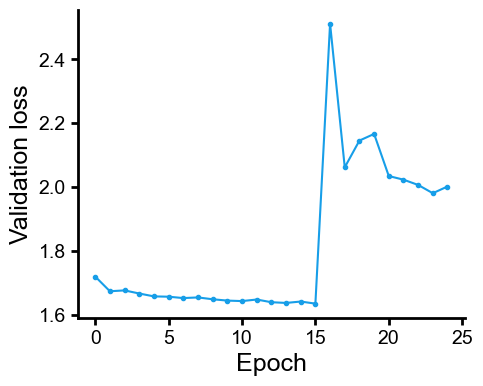

In [3]:
# Plot the loss history
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(val_loss_history[1:], '.-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation loss')
clear_spines(ax)
# ax.set(ylim=(1.4, 1.8))

In [4]:
pixel_cnn.compute_negative_log_likelihood(test_images[:500])

2023-10-22 10:33:03.165174: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-22 10:33:03.165206: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[16,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[16,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
2023-10-22 10:33:07.612978: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-22 10:33:07.613004: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[15,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[15,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}, f64[128]{0}),

1.6123151155616025

In [5]:
samples = pixel_cnn.generate_samples(4)

Generating samples:   0%|          | 0/28 [00:00<?, ?it/s]2023-10-22 10:33:11.952384: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-22 10:33:11.952410: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[4,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f64[4,64,28,28]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}
Generating samples: 100%|██████████| 28/28 [03:32<00:00,  7.58s/it]


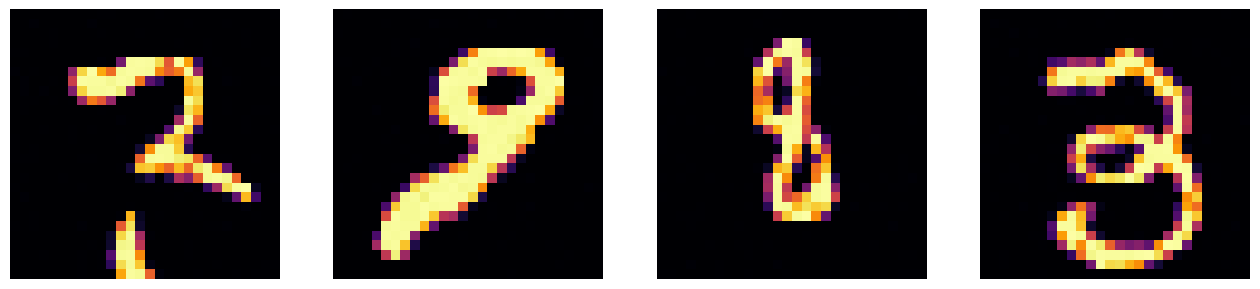

: 

In [6]:
# Plot samples
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    ax[i].imshow(samples[i], cmap='inferno')
    ax[i].axis('off')